In [1]:
%matplotlib inline
from __future__ import print_function
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


##Model background
Here is an example based on the model of Freyberg, 1988.  The synthetic model is a 2-dimensional MODFLOW model (X-Z domain) with 1 layer,  40 rows, and 20 columns.  The model has 3 stress periods: an initial steady-state stress period used for calibration, a 5-year transient stress period and a final steady-state stress period.  THe calibration period uses the recharge and well flux of Freyberg, 1988; the last two stress periods use 25% less recharge and 25% more pumping.

The inverse problem has 703 parameters: hydraulic conductivity of each active model cell, calibration and forecast period recharge multipliers, storage and specific yeild, well flux for each of the six wells, and river bed conductance for each river-type boundary.  The inverse problem has 13 head obseravtions, measured at the end of the steady-state calibration period.  The forecasts of interest include the sw-gw exchange flux during all three stress periods, the water level in each of the well cells at the end of the stress periods and the travel time from a point near the left edge of the model domain to a boundary condition (see figure).  The forecasts are included in the Jacobian matrix as zero-weight observations. The model files, pest control file and previously-calculated jacobian matrix are in the `freyberg/` folder


Freyberg, David L. "AN EXERCISE IN GROUND‐WATER MODEL CALIBRATION AND PREDICTION." Groundwater 26.3 (1988): 350-360.

  ...load method not completed. default nwt file created.


<function matplotlib.pyplot.show>

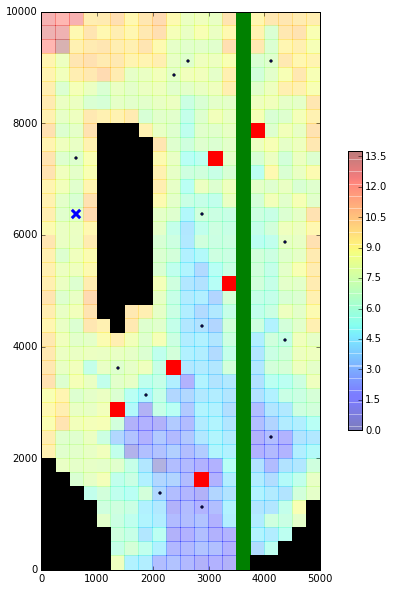

In [2]:
import flopy

# load the model
model_ws = os.path.join("Freyberg","extra_crispy")
ml = flopy.modflow.Modflow.load("freyberg",model_ws=model_ws)

# plot some model attributes
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111,aspect="equal")
ml.upw.hk.plot(axes=[ax],colorbar=True,alpha=0.3)
ml.wel.stress_period_data.plot(axes=[ax])
ml.riv.stress_period_data.plot(axes=[ax])

# plot obs locations
obs = pd.read_csv(os.path.join("freyberg","misc","obs_rowcol.dat"),delim_whitespace=True)
obs_x = [ml.dis.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [ml.dis.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.')


# plot particle starting location
loc_line = open(os.path.join(model_ws,ml.name+".locations"),'r').readlines()[-1].strip().split()
r,c = int(loc_line[4]),int(loc_line[5])
x,y = ml.dis.sr.xcentergrid[r-1,c-1],ml.dis.sr.ycentergrid[r-1,c-1]
ax.scatter([x],[y],marker='x',s=70,lw=3)

plt.show


##Using `pyemu`

In [3]:
import pyemu

First create a linear_analysis object.  We will use `ErrVar`  derived type, which replicates the behavior of the `PREDVAR` suite of PEST as well as `ident_par` utility.  We pass it the name of the jacobian matrix file.  Since we don't pass an explicit argument for `parcov` or `obscov`, `pyemu` attempts to build them from the parameter bounds and observation weights in a pest control file (.pst) with the same base case name as the jacobian.  Since we are interested in forecast uncertainty as well as parameter uncertainty, we also pass the names of the forecast sensitivity vectors we are interested in, which are stored in the jacobian as well.  Note that the `forecasts` argument can be a mixed list of observation names, other jacobian files or PEST-compatible ASCII matrix files.  Remember you can pass a filename to the `verbose` argument to write log file.

Since most groundwater model history-matching analyses focus on adjusting hetergeneous hydraulic properties and not boundary condition elements, let's identify the well flux and recharge parameters as `omitted` in the error variance analysis.  We can conceptually think of this action as excluding these parameters from the history-matching process. Later we will explicitly calculate the penalty for not adjusting these parameters.

In [35]:
# get the list of forecast names from the pest++ argument in the pest control file
jco = os.path.join("freyberg","freyberg.jcb")
pst = pyemu.Pst(jco.replace("jcb","pst"))
forecast_arg = [arg for arg in pst.pestpp_lines[0].split('++') if "forecast" in arg ][0]
forecasts = forecast_arg.replace("forecasts(",'').replace(')','').split(',')

omitted = [pname for pname in pst.par_names if pname.startswith("wf") or pname.startswith("rch")]

la = pyemu.ErrVar(jco=jco, forecasts=forecasts,verbose=True,omitted_parameters=omitted)
print(la.jco.shape)

2015-11-03 15:23:01.188000 starting: pre-loading base components

2015-11-03 15:23:01.189000 starting: loading jco: freyberg\freyberg.jcb

2015-11-03 15:23:01.297000 finished: loading jco: freyberg\freyberg.jcb took: 0:00:00.108000

2015-11-03 15:23:01.297000 starting: loading pst: freyberg\freyberg.pst

2015-11-03 15:23:01.458000 finished: loading pst: freyberg\freyberg.pst took: 0:00:00.161000

2015-11-03 15:23:01.462000 starting: loading parcov

2015-11-03 15:23:01.803000 finished: loading parcov took: 0:00:00.341000

2015-11-03 15:23:01.803000 starting: loading obscov

2015-11-03 15:23:02.397000 finished: loading obscov took: 0:00:00.594000

2015-11-03 15:23:02.397000 starting: loading forecasts

2015-11-03 15:23:02.459000 finished: loading forecasts took: 0:00:00.062000

2015-11-03 15:23:02.475000 finished: pre-loading base components took: 0:00:01.287000

2015-11-03 15:23:02.475000 starting: dropping prior information

2015-11-03 15:23:02.475000 starting: removing 761 prior info 

#Parameter identifiability
The `errvar` dervied type exposes a method to get a `pandas` dataframe of parameter identifiability information.  Recall that parameter identifiability is expressed as $d_i = \Sigma(\mathbf{V}_{1i})^2$, where $d_i$ is the parameter identifiability, which ranges from 0 (not identified by the data) to 1 (full identified by the data), and $\mathbf{V}_1$ are the right singular vectors corresonding to non-(numerically) zero singular values.  First let's look at the singular spectrum of $\mathbf{Q}^{\frac{1}{2}}\mathbf{J}$, where $\mathbf{Q}$ is the cofactor matrix and $\mathbf{J}$ is the jacobian:

In [36]:
s = la.qhalfx.s

2015-11-03 15:23:09.771000 starting: qhalfx

2015-11-03 15:23:09.771000 starting: qhalf

2015-11-03 15:23:09.779000 finished: qhalf took: 0:00:00.008000

2015-11-03 15:23:09.876000 finished: qhalfx took: 0:00:00.105000



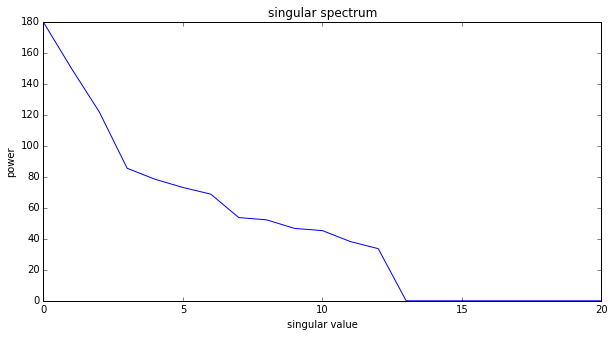

In [37]:
import pylab as plt
figure = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.plot(s.x)
ax.set_title("singular spectrum")
ax.set_ylabel("power")
ax.set_xlabel("singular value")
ax.set_xlim(0,20)
plt.show()

We see that the singluar spectrum decays rapidly (not uncommon) and that we can really only support about 13 right singular vectors even though we have 700+ parameters in the inverse problem.  

Let's get the identifiability dataframe at 13 singular vectors:

In [38]:
ident_df = la.get_identifiability_dataframe(13) # the method is passed the number of singular vectors to include in V_1
ident_df.sort("ident",ascending=False).iloc[0:10]

2015-11-03 15:23:19.523000 starting: xtqx

2015-11-03 15:23:19.948000 finished: xtqx took: 0:00:00.425000



,right_sing_vec_1,right_sing_vec_2,right_sing_vec_3,right_sing_vec_4,right_sing_vec_5,right_sing_vec_6,right_sing_vec_7,right_sing_vec_8,right_sing_vec_9,right_sing_vec_10,right_sing_vec_11,right_sing_vec_12,right_sing_vec_13,ident
hkr30c15,3.290900e-07,7.044375e-06,2.479020e-06,1.140011e-04,5.082595e-06,4.144797e-04,2.914886e-05,0.000325,0.157959,1.404472e-04,0.143139,1.370276e-02,1.826426e-04,0.316021
hkr03c11,5.003303e-02,1.404578e-02,1.739226e-02,2.993984e-05,4.063808e-05,1.548729e-06,7.199231e-09,0.000181,0.000013,1.845528e-01,0.000079,4.467137e-05,7.423482e-04,0.267156
hkr34c09,7.345083e-04,9.125997e-03,1.716865e-03,7.862148e-02,1.256701e-01,2.240252e-02,1.716067e-02,0.000011,0.000034,1.218779e-05,0.000035,3.552695e-06,5.335394e-08,0.255528
hkr04c10,6.392467e-02,1.736472e-02,1.887143e-02,3.450696e-05,6.174547e-05,1.370228e-06,1.016931e-04,0.002219,0.000054,1.491807e-01,0.000036,9.585028e-06,2.037913e-05,0.251880
hkr22c12,7.338922e-04,7.121903e-03,2.094718e-03,2.357636e-02,8.307662e-02,1.218885e-03,7.865360e-02,0.024846,0.001072,4.587448e-05,0.000250,7.825051e-04,3.000407e-05,0.223503
hkr25c06,6.255760e-03,3.622798e-02,8.721402e-04,1.046226e-01,1.543280e-02,1.869279e-03,5.109957e-02,0.000181,0.000003,2.053997e-06,0.000002,6.854118e-07,3.246756e-07,0.216569
hkr35c12,1.611155e-04,1.577611e-03,2.415478e-04,8.132104e-03,4.097179e-04,1.943214e-01,7.026843e-05,0.000066,0.001226,2.254672e-06,0.000595,3.565904e-05,7.077702e-07,0.206839
hkr35c10,8.196639e-05,1.008543e-03,1.565779e-04,3.927183e-03,1.947728e-02,1.588248e-01,3.140667e-03,0.000001,0.000499,3.390147e-07,0.000237,1.067324e-05,1.649054e-07,0.187366
hkr04c16,1.876654e-07,9.328463e-08,2.221951e-07,2.703059e-12,1.173842e-08,1.221827e-09,1.348791e-07,0.000006,0.000047,7.769099e-05,0.000595,1.033121e-02,1.672190e-01,0.178277
hkr03c15,1.888557e-07,9.070880e-08,2.262869e-07,6.054070e-10,2.804157e-08,1.102138e-09,2.113285e-07,0.000009,0.000068,7.629373e-05,0.000746,1.121317e-02,1.657981e-01,0.177912


Plot the indentifiability:

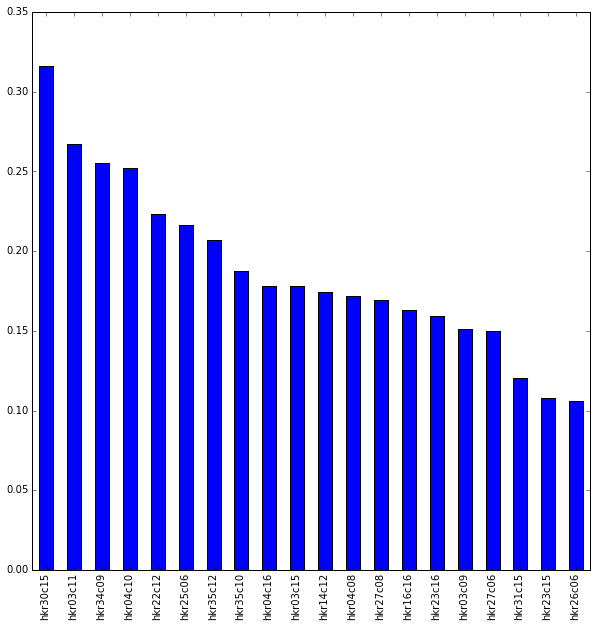

In [39]:
ident_df.sort("ident",ascending=False).iloc[0:20].loc[:,"ident"].plot(kind="bar",figsize=(10,10))

#Forecast error variance 

Now let's explore the error variance of the forecasts we are interested in.  We will use an extended version of the forecast error variance equation:   

$\sigma_{s - \hat{s}}^2 = \underbrace{\textbf{y}_i^T({\bf{I}} - {\textbf{R}})\boldsymbol{\Sigma}_{{\boldsymbol{\theta}}_i}({\textbf{I}} - {\textbf{R}})^T\textbf{y}_i}_{1} + \underbrace{{\textbf{y}}_i^T{\bf{G}}\boldsymbol{\Sigma}_{\mathbf{\epsilon}}{\textbf{G}}^T{\textbf{y}}_i}_{2} + \underbrace{{\bf{p}}\boldsymbol{\Sigma}_{{\boldsymbol{\theta}}_o}{\bf{p}}^T}_{3}$

Where term 1 is the null-space contribution, term 2 is the solution space contribution and term 3 is the model error term (the penalty for not adjusting uncertain parameters).  Remember the well flux and recharge parameters that we marked as omitted?  The consequences of that action can now be explicitly evaluated.  See Moore and Doherty (2005) and White and other (2014) for more explanation of these terms.  Note that if you don't have any `omitted_parameters`, the only terms 1 and 2 contribute to error variance

First we need to create a list (or numpy ndarray) of the singular values we want to test.  Since we have $\lt13$ data, we only need to test up to $13$ singular values because that is where the action is:

In [40]:
sing_vals = np.arange(14)

The `ErrVar` derived type exposes a convience method to get a multi-index pandas dataframe with each of the terms of the error variance equation:

In [41]:
errvar_df = la.get_errvar_dataframe(sing_vals)
errvar_df.iloc[0:10]

2015-11-03 15:25:07.722000 starting: calc first term parameter @0

2015-11-03 15:25:08.039000 finished: calc first term parameter @0 took: 0:00:00.317000

2015-11-03 15:25:08.045000 starting: calc second term prediction @0

2015-11-03 15:25:08.275000 finished: calc second term prediction @0 took: 0:00:00.230000

2015-11-03 15:25:08.290000 starting: calc third term prediction @0

2015-11-03 15:25:08.306000 finished: calc third term prediction @0 took: 0:00:00.016000

2015-11-03 15:25:08.306000 starting: calc first term parameter @1

2015-11-03 15:25:08.493000 finished: calc first term parameter @1 took: 0:00:00.187000

2015-11-03 15:25:08.493000 starting: calc second term prediction @1

2015-11-03 15:25:08.493000 starting: calc G @1

2015-11-03 15:25:08.784000 finished: calc G @1 took: 0:00:00.291000

2015-11-03 15:25:08.993000 finished: calc second term prediction @1 took: 0:00:00.500000

2015-11-03 15:25:08.998000 starting: calc third term prediction @1

2015-11-03 15:25:09.020000 fin

first                                                second  \
       sw_gw_0       sw_gw_1      sw_gw_2      travel_time   sw_gw_0   
0  2346.665821  93125.784926  1067.876383  33825346.033203  0.000000   
1  2303.549610  93110.827506  1056.606905  33719999.681477  0.005339   
2  2102.765303  93068.907674   978.220242  33147479.507399  0.041015   
3  2089.014733  93064.556546   970.400492  33143875.151313  0.044716   
4  1983.078837  92997.985538   862.072618  32960132.481832  0.102688   
5  1954.419189  92889.842807   770.868011  32783277.847918  0.121333   
6  1711.734073  92816.789339   700.421814  31461500.042545  0.302842   
7  1711.318522  92816.498975   695.865282  31439291.416619  0.303194   
8  1711.256559  92812.101557   695.843263  31413845.412441  0.303280   
9  1711.072750  92807.664617   695.519153  30390576.310656  0.303549   

                                           third                 \
    sw_gw_1   sw_gw_2  travel_time       sw_gw_0        sw_gw_1   
0  0.000000  0.000000     0.000000  77287.368771  528004.087309   
1  0.001852  0.001395    13.044312  79803.910763  527856.831388   
2  0.009300  0.015323   114.771122  83589.846855  528026.436736   
3  0.010472  0.017428   115.741232  83277.644444  528008.469992   
4  0.046902  0.076710   216.292816  84472.068866  528106.372047   
5  0.117257  0.136045   331.349408  84344.766476  528081.019959   
6  0.171895  0.188733  1319.933427  85827.045559  528168.889888   
7  0.172140  0.192584  1338.706233  85874.613359  528173.174691   
8  0.178240  0.192615  1374.004428  85908.151572  528143.007383   
9  0.184747  0.193090  2874.564342  85974.258421  528108.577193   

                                  
         sw_gw_2     travel_time  
0  661863.128992  3342630.976486  
1  661868.512979  3393001.613388  
2  661905.459273  3681513.039837  
3  661900.262617  3671270.972086  
4  661930.527022  3778299.610271  
5  661924.882755  3757178.367640  
6  661950.179800  4053424.044333  
7  661955.155900  4022780.648928  
8  661955.792996  4082900.879750  
9  661952.989701  4605641.550711

plot the error variance components for each forecast:

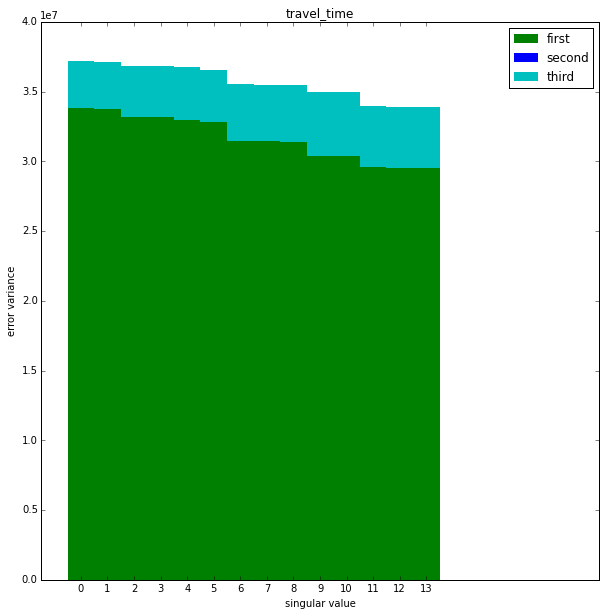

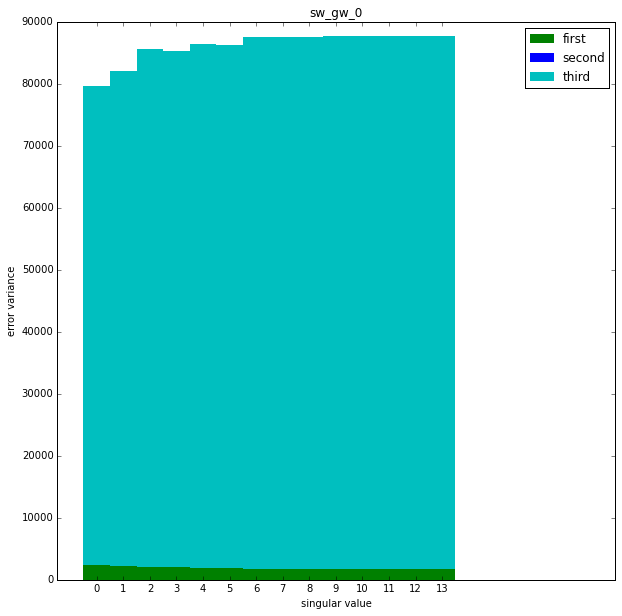

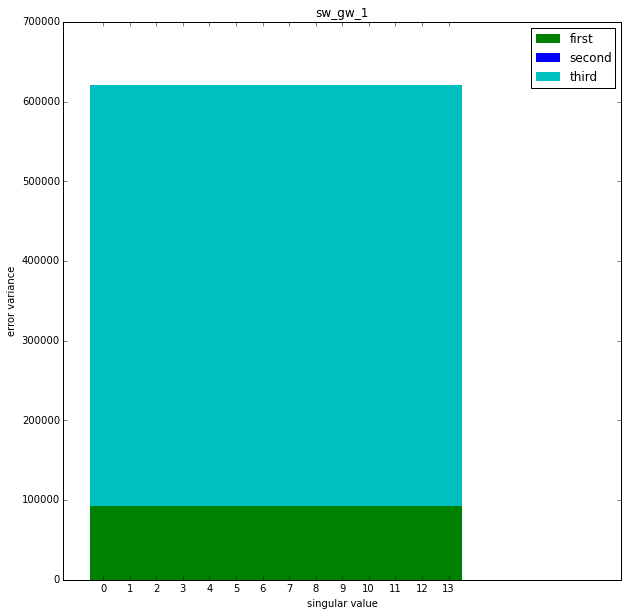

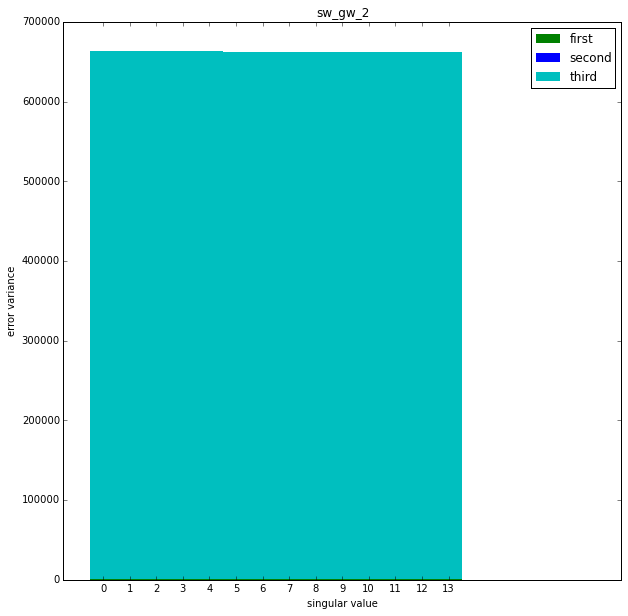

In [42]:

colors = {"first": 'g', "second": 'b', "third": 'c'}
max_idx = 19
idx = sing_vals[:max_idx]
for ipred, pred in enumerate(forecasts):
    pred = pred.lower()
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    ax.set_title(pred)
    first = errvar_df[("first", pred)][:max_idx]
    second = errvar_df[("second", pred)][:max_idx]
    third = errvar_df[("third", pred)][:max_idx]
    ax.bar(idx, first, width=1.0, edgecolor="none", facecolor=colors["first"], label="first",bottom=0.0)
    ax.bar(idx, second, width=1.0, edgecolor="none", facecolor=colors["second"], label="second", bottom=first)
    ax.bar(idx, third, width=1.0, edgecolor="none", facecolor=colors["third"], label="third", bottom=second+first)
    ax.set_xlim(-1,max_idx+1)
    ax.set_xticks(idx+0.5)
    ax.set_xticklabels(idx)
    #if ipred == 2:
    ax.set_xlabel("singular value")
    ax.set_ylabel("error variance")
    ax.legend(loc="upper right")
plt.show()


Here we see the trade off between getting a good fit to push down the null-space (1st) term and the penalty for overfitting (the rise of the solution space (2nd) term)).  The sum of the first two terms in the "appearent" error variance (e.g. the uncertainty that standard analyses would yield) without considering the contribution from the omitted parameters.  You can verify this be checking prior uncertainty from the Schur's complement notebook against the zero singular value result using only terms 1 and 2.

We also see the added penalty for not adjusting the well flux and recharge parameters.  for sw_gw_1, sw_gw_2 and travel time, forecast uncertainty is underestimated, which is already a terrible results.  For sw_gw_0, the situation is even worse: calibration increases the uncertainty for this forecast because the adjustable parametres are compensating for the omitted, uncertaint parameters in ways that are damanaging to the forecast.  

Let's check the ```errvar``` results against the results from ```schur```. This is simple with ```pyemu```, we simply  cast the ```errvar``` type to a ```schur``` type:

In [43]:
schur = la.get(astype=pyemu.Schur)
schur_prior = schur.prior_forecast
schur_post = schur.posterior_forecast
print("{0:10s} {1:>12s} {2:>12s} {3:>12s} {4:>12s}"
      .format("forecast","errvar prior","errvar min",
              "schur prior", "schur post"))
for ipred, pred in enumerate(forecasts):
    first = errvar_df[("first", pred)][:max_idx]
    second = errvar_df[("second", pred)][:max_idx]  
    min_ev = np.min(first + second)
    prior_ev = first[0] + second[0]
    prior_sh = schur_prior[pred]
    post_sh = schur_post[pred]
    print("{0:12s} {1:12.6f} {2:12.6f} {3:12.6} {4:12.6f}"
          .format(pred,prior_ev,min_ev,prior_sh,post_sh))

2015-11-03 15:33:23.987000 WARNING: LinearAnalysis.get(): astype is not None, but par_names and obs_names are None so
  ->Omitted attributes will not be propagated to new instance

forecast   errvar prior   errvar min  schur prior   schur post
travel_time  33825346.033203 29524872.978303  3.38253e+07 29524866.254115
sw_gw_0       2346.665821  1711.075829      2346.67  1711.075639
sw_gw_1      93125.784926 92807.404988      93125.8 92807.404858
sw_gw_2       1067.876383   695.652556      1067.88   695.652438


We see that the prior from ```schur``` class matches the two-term ```errvar``` result at zero singular values.  We also see, as expected, the posterior from ```schur``` is slightly lower than the two-term ```errvar``` result.  This shows us that the "appearent" uncertainty in these predictions, as found through application of Bayes equation, is being under estimated because if the ill effects of the omitted ```mult1``` and ```mult2``` parameters.